# K MEANS CLUSTERING


In [1]:
### import packages
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pickle

# CREATING THE DATA

In [2]:
# Import tables

In [3]:
transactions = pd.read_excel(r"C:\Users\12176\Desktop\lab\Data science\5. Machine_learning\2. Datasets/grocery_database.xlsx", sheet_name = "transactions")
product_areas = pd.read_excel(r"C:\Users\12176\Desktop\lab\Data science\5. Machine_learning\2. Datasets/grocery_database.xlsx", sheet_name = "product_areas")

In [4]:
transactions.head(3)

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97


In [5]:
product_areas.head(3)

,product_area_id,product_area_name,profit_margin
0,1,Non-Food,0.25
1,2,Vegetables,0.18
2,3,Fruit,0.14


In [6]:
### merge the dataframes on product area id column

In [7]:
transactions_new = pd.merge(transactions, product_areas, how ="inner", on = "product_area_id")
transactions_new.head(3)

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14


In [8]:
### drop the non-food category from product area name column as we are grouping based on food items


In [9]:
transactions_new.drop(transactions_new[transactions_new["product_area_name"] == "Non-Food"].index , inplace =True)

In [10]:
### aggregating the sales at customer level (by product areas)

In [11]:
transactions_summary = transactions_new.groupby([ "customer_id", "product_area_name"]).agg({"sales_cost": "sum"}).reset_index()

In [12]:
transactions_summary.head()

,customer_id,product_area_name,sales_cost
0,1,Dairy,367.74
1,1,Fruit,276.00
2,1,Meat,543.38
3,1,Vegetables,167.12
4,2,Dairy,150.63


In [13]:
transactions_summary.describe()

,customer_id,sales_cost
count,3156.000000,3156.000000
mean,433.668251,254.308736
std,251.003289,235.703661
min,1.000000,2.030000
25%,217.000000,114.445000
50%,433.000000,202.895000
75%,651.000000,312.240000
max,870.000000,2080.370000


In [14]:
### pivot data to place product area as columns

In [15]:
transactions_summary_pivot = transactions_new.pivot_table(index = "customer_id",
                                                   columns = "product_area_name",
                                                   values = "sales_cost",
                                                   aggfunc ="sum",
                                                   fill_value =0,
                                                   margins =True,
                                                   margins_name ="Total").rename_axis(None, axis =1)
## margins for getting the total value column
## rename axis(None) for not getting both customer_id and prduct_area_name as an index

In [16]:
transactions_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32
...,...,...,...,...,...
867,129.84,176.73,180.49,88.83,575.89
868,225.59,358.89,343.26,189.24,1116.98
869,126.28,127.50,183.88,168.85,606.51


In [17]:
### convert sales into % sales

In [18]:
transactions_summary_pivot = transactions_summary_pivot.div(transactions_summary_pivot["Total"], axis =0)
transactions_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,1.0
868,0.201964,0.321304,0.307311,0.169421,1.0
869,0.208208,0.210219,0.303177,0.278396,1.0


In [19]:
## dropping the total colunn

In [20]:
data_for_clustering = transactions_summary_pivot.drop(["Total"], axis =1)

In [21]:
data_for_clustering.describe()

,Dairy,Fruit,Meat,Vegetables
count,871.000000,871.000000,871.000000,871.000000
mean,0.215899,0.327626,0.281782,0.174693
std,0.118519,0.149865,0.178622,0.095281
min,0.000000,0.000000,0.000000,0.000000
25%,0.160698,0.228178,0.177093,0.114175
50%,0.221987,0.293287,0.333792,0.150449
75%,0.278262,0.387911,0.400213,0.205586
max,0.878670,0.812381,0.928034,0.749433


In [22]:
### Checking the correlation

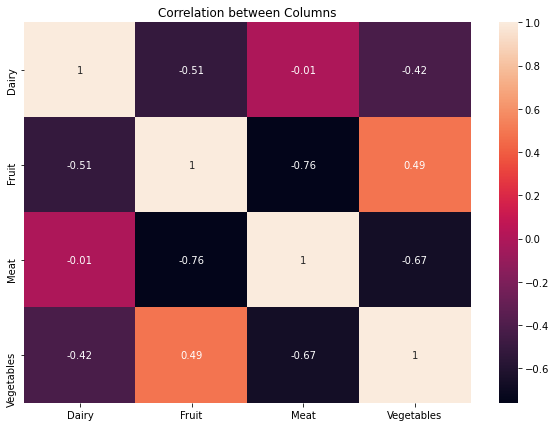

In [23]:
plt.figure(figsize = (10, 7))
sns.heatmap(data_for_clustering.corr(), annot=True)
plt.title("Correlation between Columns")
plt.show()

# DATA PREPARATION AND DATA CLEANING

In [24]:
## Checking the missing values

In [25]:
data_for_clustering.isna().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

In [26]:
### Scaling the data (Normalisation)

In [27]:
norm_scaler = MinMaxScaler()

In [28]:
data_for_clustering_scaled = pd.DataFrame(norm_scaler.fit_transform(data_for_clustering), columns = data_for_clustering.columns)

In [29]:
data_for_clustering_scaled.head()

,Dairy,Fruit,Meat,Vegetables
0,0.309044,0.250873,0.432358,0.164665
1,0.280196,0.243305,0.424823,0.216022
2,0.162172,0.286229,0.568751,0.129640
3,0.388187,0.301300,0.293237,0.189487
4,0.242132,0.307357,0.463709,0.143065


In [30]:
## Pickling the scaler

In [31]:
pickle.dump(norm_scaler, open('norm_sclaer.pkl', 'wb'))

# USING WCSS and KElbowVisualizer FOR FINDING GOOD VALUE OF K

In [32]:
k_values = list(range(1,11))
wcss_list = []
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state =42)
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)

C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

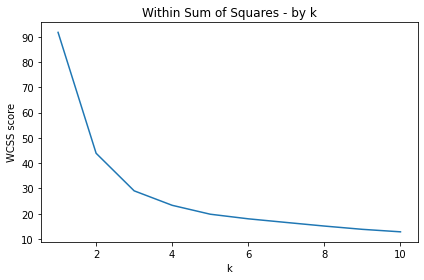

In [33]:
plt.plot(k_values, wcss_list)
plt.title("Within Sum of Squares - by k")
plt.xlabel("k")
plt.ylabel("WCSS score")
plt.tight_layout()
plt.show()

In [34]:
### using KEbowVisualizer

C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

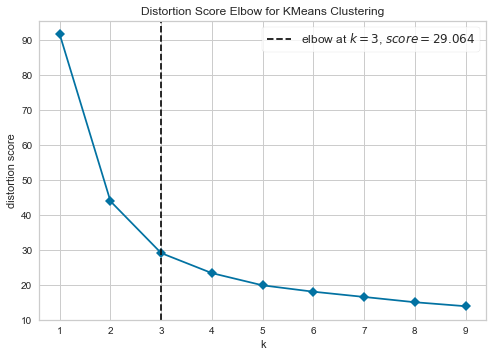

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k =(1,10), timings = False)
visualizer.fit(data_for_clustering_scaled)
visualizer.show()

# INSTANTIATE & FIT THE MODEL

In [36]:
kmeans = KMeans(n_clusters = 3, random_state =42)
kmeans.fit(data_for_clustering_scaled)

C:\Users\12176\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

# USING CLUSTER INFO

In [37]:
## Adding cluster lables to our data

In [38]:
data_for_clustering["cluster"]= kmeans.labels_
data_for_clustering
## we are using the original data (not scaled)

,Dairy,Fruit,Meat,Vegetables,cluster
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,0
2,0.246200,0.197656,0.394250,0.161894,0
3,0.142496,0.232527,0.527821,0.097156,0
4,0.341088,0.244770,0.272134,0.142008,0
5,0.212754,0.249691,0.430338,0.107218,0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,0
868,0.201964,0.321304,0.307311,0.169421,0
869,0.208208,0.210219,0.303177,0.278396,0


In [39]:
### Checking cluster size

In [40]:
data_for_clustering["cluster"].value_counts()

0    641
2    127
1    103
Name: cluster, dtype: int64

# PROFILING THE CLUSTERS

In [41]:
cluster_summary = data_for_clustering.groupby("cluster")[["Dairy", "Fruit", "Meat", "Vegetables"]].mean()

In [42]:
cluster_summary

,Dairy,Fruit,Meat,Vegetables
cluster,,,,
0,0.220875,0.264605,0.376508,0.138011
1,0.002382,0.637796,0.003696,0.356126
2,0.363948,0.394152,0.029210,0.212690


# Pickling the Model

In [43]:
pickle.dump(kmeans, open('Kmeans_model.pkl', 'wb'))